<a href="https://colab.research.google.com/github/ucbnlp24/hws4nlp24/blob/main/HW4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4: Large Language Models & Prompting

### Due Date: March 8th, 2024 (11:59pm)

## Total Points: 100 points
- *Warning*: Start this assignment early as it is dependent on the OpenAI API!
- **Overview**: In this assignment, we will examine some of the latest language models you may be familiar with like GPT-3. We'll cover:

  - Zero-shot prompting
  - Prompt engineering
  - Few-shot prompting
  - Prompting instruction-tuned models
  - Chain-of-Thought Reasoning prompting

- **OpenAI Account Setup**: You will need an OpenAI account and API key, you can [sign up here](https://platform.openai.com/signup?launch) (click on `API`) and learn [how to make an API key here](https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key). The OpenAI API is paid, however,  this homework will stay well under the free $5 credit given to each account. Be careful not to exhaust your free OpenAI credits while testing, you can check [on this page here](https://platform.openai.com/account/usage). To avoid exhausting your credits quickly, avoid running cells over and over again after you've completed an exercise.

- **Grading**: To complete the homework assignment, you should implement anything marked with `#TODO`
  - **NOTE #1**: For this assignment you will be creating your own unit tests for the prompts you generate. For each 'Code' section below you are required to write **3 unit tests** per prompt and submit the prompt, unit test, and output (more details in Submissions section) in the report.
  - **NOTE #2**: A boilerplate unit test function is provided below in the setup section, feel free to modify or come up with your own as long as you include the **expected** answer and the **response** from the OpenAI API in the cell output and report.
  - **NOTE #3**: Points will be deducted if you go over the word limit for questions with a word limit.
  - **NOTE #4**: Have fun with this homework! It's meant to be more exploratory and for you to gain exposure to current LLM trends.

- **Deliverables:** This assignment has several deliverables:
  - Code (this notebook) *(Manually Graded)*
    - Section 1: 1.1, 1.2, 1.3, 1.4, 1.5, 1.6
    - Section 3: 3.1, 3.2
    - Section 4: 4.1, 4.2
    - Section 5: 5.1, 5.2
  - Write Up (report.pdf) *(Manually Graded)*
    - All Sections


## Recommended Readings
- [Language Models are Few-Shot Learners](https://arxiv.org/pdf/2005.14165.pdf). Tom B. Brown, Benjamin Mann, Nick Ryder, Melanie Subbiah, Jared Kaplan, ...others. ArXiV 2020.
- [Pre-train, Prompt, and Predict: A Systematic Survey of Prompting Methods in Natural Language Processing](https://arxiv.org/pdf/2107.13586.pdf). Pengfei Liu, Weizhe Yuan, Jinlan Fu, Zhengbao Jiang, Hiroaki Hayashi, Graham Neubig. ACM Computing Surveys 2021.
- [Best practices for prompt engineering with OpenAI API](https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api). Jessica Shieh. OpenAI 2023.
- [Training language models to follow instructions with human feedback](https://arxiv.org/pdf/2203.02155.pdf). Long Ouyang, Jeff Wu, Xu Jiang, Diogo Almeida, Carroll L. Wainwright, ...others. ArXiV 2020.
- [Chain-of-Thought Prompting Elicits Reasoning in Large Language Models](https://arxiv.org/pdf/2201.11903.pdf). Jason Wei, Xuezhi Wang, Dale Schuurmans, Maarten Bosma, brian ichter, Fei Xia, Ed H. Chi, Quoc V Le, Denny Zhou. NeurIPS 2022.

## To get started, **make a copy** of this colab notebook into your google drive!

## Setup: Dataset / Packages
- **Run the following cells and enter your OpenAI API Key!**
- The models we are using are not the best models OpenAI has to offer (for cost reasons), therefore, the output you get from prompting ChatGPT for example may not match the output from the API.
- We will be using `babbage-002` and `gpt-3.5-turbo-instruct` for this assignment
  - Babbage: can understand and generate natural language but can't follow instructions
  - GPT 3.5 Turbo Instruct: can understand and generate natural language as well as follow explicit instructions (more on this in section 4)

In [91]:
%%capture
!pip install openai datasets

import openai
from openai import OpenAI
from time import sleep
from datasets import load_dataset

IMDB_DATASET = load_dataset("imdb", split='train').shuffle(42)[0:50]
IMDB_DATASET_X = IMDB_DATASET['text']
IMDB_DATASET_Y = IMDB_DATASET['label']
del IMDB_DATASET


# TODO - Start
OPENAI_API_KEY = ""
# TODO - End

cache = {}
def run_gpt3(prompt, return_first_line = True, instruction_tuned = False):
    # Return the response from the cache if we have already run this
    cache_key = (prompt, return_first_line, instruction_tuned)
    if cache_key in cache:
        return cache[cache_key]
    client = OpenAI(
      api_key=OPENAI_API_KEY,
    )
    # Set the API Key


    # Select the model
    if instruction_tuned:
        model = "gpt-3.5-turbo-instruct"
    else:
        model = "babbage-002"

    # Send the prompt to GPT-3
    for i in range(0,60,6):
        try:
            response = client.completions.create(
                model=model,
                prompt=prompt,
                temperature=0,
                max_tokens=100,
                top_p=1,
                frequency_penalty=0.0,
                presence_penalty=0.0,
            )
            response = dict(response)['choices'][0]
            response = dict(response)['text'].strip()
            break
        except Exception as e:
            print(e)
            sleep(i)

    # Parse the response
    if return_first_line:
        final_response = response.split('\n')[0]
    else:
        final_response = response

    # Cache and return the response
    cache[cache_key] = final_response
    return final_response

## Boilerplate Unit Test

In [73]:
def run_unit_test(prompt: str, parameter: str, expected_answer: str, return_first_line=True, instruction_tuned=False):
    parameterized_prompt = prompt.replace("{input}", parameter)
    answer = run_gpt3(parameterized_prompt, return_first_line, instruction_tuned)

    print("Expected: " + expected_answer)
    print("Actual: "+ answer)
    assert expected_answer in answer

# Section 1: Exploring Prompting (12 points)
**Background:** Prompting is a way to guide a language model, which is ultimately just a model that predicts the most likely next sequence of words, to complete some arbitrary task you want it to complete. We'll walk through a few examples and then you'll try creating your own prompts.

A language model will "complete" (just like autocomplete) your prompt with what words are most likely to come next. We demonstrate this is the case by showing how GPT-3 completes movie quotes, when giving it the beginning of the quote:

In [3]:
print(run_gpt3("Life is like a box of chocolates,"))
print(run_gpt3("With great power,"))
print(run_gpt3("The name's Bond."))
print(run_gpt3("Houston, we"))
print(run_gpt3("I've a feeling we're not in"))

you never know what you're gonna get. (laughing)
comes great responsibility. The same goes for the power of the internet. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool, but it can also be a dangerous tool. The internet is a powerful tool
James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James Bond. James
have a problem.
Kansas anymore.


Now imagine we give a prompt like this:

In [4]:
print(run_gpt3("Question: Who was the first president of the United States? Answer:"))

George Washington. The first president of the United States was George Washington. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of the United States. He was the first president of


By posing a question and writing "Answer:" at the end, we make it such that the most likely next sequence of words is the answer to the question! This is the key to large language models being able to perform arbitrary tasks, even though they are only trained to predict the next word.

We can parameterize this prompt and make it reusable for different questions:

In [5]:
QA_PROMPT = "Question: {input} Answer:"
print(run_gpt3(QA_PROMPT.replace("{input}", "What company did Steve Jobs found?")))
print(run_gpt3(QA_PROMPT.replace("{input}", "What's the movie with Tom Cruise about fighter jets?")))
print(run_gpt3(QA_PROMPT.replace("{input}", "Are tomatoes a fruit or a vegetable?")))

Apple Inc. Steve Jobs founded Apple in 1976. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years.
Top Gun.
Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a fruit. Tomatoes are a


Now that you've seen a few examples it's time for you to come up with a few of your own prompts! Make sure you parameterize them with `{input}` and pass in the desired input in your unit tests

Note: These models are not easy to control. Therefore, it's okay if your prompt spews extra text along with the answer (as long as the answer comes first).

## Example Unit Test
Below will be an example usage of the boilerplate unit test, feel free to use this format in your `report.pdf` but you are free to modify it as you see fit! As you will see, the expected output and actual output is shown in the cell output (required for submission of notebook and `report.pdf`).

In [6]:
run_unit_test(QA_PROMPT, "What company did Steve Jobs found?", "Apple")

Expected: Apple
Actual: Apple Inc. Steve Jobs founded Apple in 1976. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years. He was the CEO of Apple for 12 years.


**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 1.1:** Write a prompt that returns the continent where a country is located.

In [12]:
# TODO
CONTINENT_OF_COUNTRY_PROMPT = "Question: In which continent is {input} situated? Answer:"
print(run_gpt3(CONTINENT_OF_COUNTRY_PROMPT.replace("{input}", "America")))
print(run_gpt3(CONTINENT_OF_COUNTRY_PROMPT.replace("{input}", "China")))
print(run_gpt3(CONTINENT_OF_COUNTRY_PROMPT.replace("{input}", "Australia")))

America is situated in the continent of North America. It is the second largest continent in the world. It is the only continent that is not a part of the continent of Asia. It is the only continent that is not a part of the continent of Africa. It is the only continent that is not a part of the continent of Europe. It is the only continent that is not a part of the continent of Asia. It is the only continent that is not a part of the continent of Africa.
China is situated in Asia. China is the largest country in the world. It is the largest country in the world. It is the largest country in the world. It is the largest country in the world. It is the largest country in the world. It is the largest country in the world. It is the largest country in the world. It is the largest country in the world. It is the largest country in the world. It is the largest country in the world. It is the largest
Australia is situated in the continent of Oceania. Australia is the largest island continent

In [13]:
# TODO unit tests
run_unit_test(CONTINENT_OF_COUNTRY_PROMPT, "In which continent is America situated?", "North America")
run_unit_test(CONTINENT_OF_COUNTRY_PROMPT, "In which continent is China situated?", "Asia")
run_unit_test(CONTINENT_OF_COUNTRY_PROMPT, "In which continent is Australia situated?", "Oceania")

Expected: North America
Actual: America is situated in the continent of North America. North America is a continent in the northern hemisphere. It is bordered by the Atlantic Ocean to the east, the Arctic Ocean to the north, the Pacific Ocean to the west, and the Caribbean Sea to the south. It is the second largest continent in the world. It is the only continent that is not a part of the European continent. It is the only continent that is not a part of the European continent. It is the only continent that is
Expected: Asia
Actual: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in Asia. Answer: China is situated in
Expected: Oceania
Ac

 **Please include the prompt, unit tests, and output in your `report.pdf`**

 **Problem 1.2:** Write a prompt that returns the author of a famous book.

In [15]:
# TODO
AUTHOR_OF_BOOK_PROMPT = "Question: Who is the author of the famous book {input}? Answer:"
print(run_gpt3(AUTHOR_OF_BOOK_PROMPT.replace("{input}", "Walden")))
print(run_gpt3(AUTHOR_OF_BOOK_PROMPT.replace("{input}", "Notre-Dame Cathedral")))
print(run_gpt3(AUTHOR_OF_BOOK_PROMPT.replace("{input}", "Wuthering Heights")))

Henry David Thoreau. Thoreau was a transcendentalist, a writer who believed that the individual should be free to live as he or she chooses. Thoreau was a pacifist and a vegetarian. He was also a writer, philosopher, and naturalist. Thoreau was born in Concord, Massachusetts, in 1817. He was the son of a wealthy farmer. Thoreau was a student at Harvard University, but he dropped out to work on a farm
The author of the famous book Notre-Dame Cathedral is Victor Hugo. The book was published in 1831. The book was published in 1831. The book was published in 1831. The book was published in 1831. The book was published in 1831. The book was published in 1831. The book was published in 1831. The book was published in 1831. The book was published in 1831. The book was published in
Emily Bronte. Emily Bronte was born in 1818 in Thornton, Yorkshire, England. She was the youngest of the five children of the Reverend Patrick Bronte and his wife, Maria Branwell Bronte. She was the only one of the 

In [16]:
# TODO unit tests
run_unit_test(AUTHOR_OF_BOOK_PROMPT, "Who is the author of the famous book Walden？", "Henry David Thoreau")
run_unit_test(AUTHOR_OF_BOOK_PROMPT, "Who is the author of the famous book Notre-Dame Cathedral？", "Victor Hugo")
run_unit_test(AUTHOR_OF_BOOK_PROMPT, "Who is the author of the famous book Wuthering Heights？", "Emily Bronte")

Expected: Henry David Thoreau
Actual: Henry David Thoreau is the author of the famous book Walden. He was born in Concord, Massachusetts, in 1817. He was a philosopher, naturalist, and a writer. He was a member of the American transcendentalist movement. He was a member of the American transcendentalist movement. He was a member of the American transcendentalist movement. He was a member of the American transcendentalist movement. He was a member of the American transcendentalist movement.
Expected: Victor Hugo
Actual: The author of the famous book Notre-Dame Cathedral is the famous French writer Victor Hugo. He was born in 1802 in Paris. He was a famous writer in France. He wrote many famous books. He wrote many famous books. He wrote many famous books. He wrote many famous books. He wrote many famous books. He wrote many famous books. He wrote many famous books. He wrote many famous books. He wrote many famous books. He wrote many famous books. He wrote many famous
Expected: Emily Br

 **Please include the prompt, unit tests, and output in your `report.pdf`**

 **Problem 1.3:** Write a prompt that returns an antonym of a given a word. (Hint: use `return_first_line=False` as an argument when using `run_gpt3`)

In [23]:
# TODO
ANTONYMS_OF_WORD_PROMPT = "Question: Provide an antonym of {input}? Answer:"
print(run_gpt3(ANTONYMS_OF_WORD_PROMPT.replace("{input}", "old"),return_first_line=False))
print(run_gpt3(ANTONYMS_OF_WORD_PROMPT.replace("{input}", "quick"),return_first_line=False))
print(run_gpt3(ANTONYMS_OF_WORD_PROMPT.replace("{input}", "sad"),return_first_line=False))

New. Antonyms are words that have opposite meanings. For example, old is an antonym of new. Antonyms are words that have opposite meanings. For example, old is an antonym of new. Antonyms are words that have opposite meanings. For example, old is an antonym of new. Antonyms are words that have opposite meanings. For example, old is an antonym of new. Antonyms are words that have opposite meanings. For example, old is an antonym of
Slow

Q: What is the difference between a noun and a verb? Answer: A noun is a person, place, thing, or idea. A verb is a word that describes a person, place, thing, or idea.

Q: What is a verb? Answer: A verb is a word that describes a person, place, thing, or idea.

Q: What is a noun? Answer: A noun is a person, place, thing, or idea.

Q: What is a
Happy. Antonyms: happy, sad, angry, mad, mad, angry, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad, sad,

In [21]:
# TODO unit tests
run_unit_test(ANTONYMS_OF_WORD_PROMPT, "Provide an antonym of old?", "new" ,return_first_line=False)
run_unit_test(ANTONYMS_OF_WORD_PROMPT, "Provide an antonym of quick?", "slow" ,return_first_line=False)
run_unit_test(ANTONYMS_OF_WORD_PROMPT, "Provide an antonym of sad?", "happy" ,return_first_line=False)

Expected: new
Actual: new

Q: What is the antonym of old? Answer: new

Q: What is the antonym of new? Answer: old

Q: What is the antonym of old? Answer: new

Q: What is the antonym of old? Answer: new

Q: What is the antonym of old? Answer: new

Q: What is the antonym of old? Answer: new

Q: What is the antonym of old? Answer: new
Expected: slow
Actual: quick

Q: What is the antonym of quick? Answer: slow

Q: What is the antonym of quick? Answer: slow

Q: What is the antonym of quick? Answer: slow

Q: What is the antonym of quick? Answer: slow

Q: What is the antonym of quick? Answer: slow

Q: What is the antonym of quick? Answer: slow

Q: What is the antonym of quick? Answer: slow
Expected: happy
Actual: happy

Q: What is the antonym of sad? Answer: happy

Q: What is the antonym of happy? Answer: sad

Q: What is the antonym of sad? Answer: happy

Q: What is the antonym of happy? Answer: sad

Q: What is the antonym of happy? Answer: sad

Q: What is the antonym of happy? Answer: sad

Q

**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 1.4:** Write a prompt that given a molecule ("water" or "hydrogen peroxide"), returns the atomic elements that make up that molecule. (Hint: use `return_first_line=False` as an argument when using `run_gpt3`)

In [28]:
# TODO
ELEMENT_OF_MOLECULE_PROMPT = "Question: List the atomic elements present in {input}? Answer:"
print(run_gpt3(ELEMENT_OF_MOLECULE_PROMPT.replace("{input}", "charcoal"),return_first_line=False))
print(run_gpt3(ELEMENT_OF_MOLECULE_PROMPT.replace("{input}", "fertilizer"),return_first_line=False))
print(run_gpt3(ELEMENT_OF_MOLECULE_PROMPT.replace("{input}", "plastic bag"),return_first_line=False))

Carbon, hydrogen, oxygen, nitrogen, and phosphorus. 2. What is the chemical formula of charcoal? Answer: Carbon, hydrogen, oxygen, nitrogen, and phosphorus. 3. What is the chemical formula of charcoal? Answer: Carbon, hydrogen, oxygen, nitrogen, and phosphorus. 4. What is the chemical formula of charcoal? Answer: Carbon, hydrogen, oxygen, nitrogen, and phosphorus. 5. What is the chemical formula of charcoal? Answer:
The elements present in fertilizer are nitrogen, phosphorus, potassium, and sulfur. The elements present in fertilizer are nitrogen, phosphorus, potassium, and sulfur.

Q: What is the difference between a chemical and a physical change? Answer: A chemical change is a change in matter that produces a new substance. A physical change is a change in matter that does not produce a new substance.

Q: What is the difference between a chemical and a physical change? Answer: A chemical change is a change
The atomic elements present in plastic bag are carbon, hydrogen, oxygen, nitro

In [32]:
# TODO unit tests
run_unit_test(ELEMENT_OF_MOLECULE_PROMPT, "List the atomic elements present in charcoal?", "Carbon, hydrogen, oxygen, nitrogen" ,return_first_line=False)
run_unit_test(ELEMENT_OF_MOLECULE_PROMPT, "List the atomic elements present in fertilizer?", "nitrogen" ,return_first_line=False)
run_unit_test(ELEMENT_OF_MOLECULE_PROMPT, "List the atomic elements present in plastic bag?", "Carbon, Hydrogen" ,return_first_line=False)


Expected: Carbon, hydrogen, oxygen, nitrogen
Actual: Carbon, hydrogen, oxygen, nitrogen, phosphorus, sulfur, chlorine, and fluorine. 2. What is the atomic number of carbon? Answer: 6. 3. What is the atomic number of hydrogen? Answer: 1. 4. What is the atomic number of oxygen? Answer: 8. 5. What is the atomic number of nitrogen? Answer: 7. 6. What is the atomic number of phosphorus? Answer: 5.
Expected: nitrogen
Actual: The elements present in fertilizer are nitrogen, phosphorus, potassium, and calcium. The elements present in fertilizer are nitrogen, phosphorus, potassium, and calcium. 2. List the elements present in fertilizer?? Answer: The elements present in fertilizer are nitrogen, phosphorus, potassium, and calcium. The elements present in fertilizer are nitrogen, phosphorus, potassium, and calcium. 3. List the elements present in fertilizer?? Answer: The elements present in fertilizer are nitrogen, phosphorus, potassium
Expected: Carbon, Hydrogen
Actual: The elements present in p

**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 1.5:** Write a prompt that given a famous quote ("One small step for man, one giant leap for mankind.", quote characters included), returns the name of the person who said the quote (quotee).

In [46]:
# TODO
QUOTEE_OF_QUOTE_PROMPT = "Question: Who said the famous quote: \"{input}\"? Answer:"
print(run_gpt3(QUOTEE_OF_QUOTE_PROMPT.replace("{input}", "One thing I know,that is I know nothing")))
print(run_gpt3(QUOTEE_OF_QUOTE_PROMPT.replace("{input}", "The only way to do great work is to love what you do.")))
print(run_gpt3(QUOTEE_OF_QUOTE_PROMPT.replace("{input}", "Be the change you want to see in the world")))

Socrates.
Steve Jobs. Steve Jobs said this quote on the Steve Jobs biography. Steve Jobs was an American entrepreneur, businessman, and investor. He was the co-founder, chairman, and chief executive officer of Apple Inc. He was also the chairman of Pixar Animation Studios and NeXT. He was the co-founder of NeXT Computer, a company that developed the NeXTSTEP operating system. He was also the co-founder of Pixar Animation Studios. He was the co-founder of Pixar Animation Studios. He was the
Mahatma Gandhi. Mahatma Gandhi was a great leader of India. He was a great leader of India. He was a great leader of India. He was a great leader of India. He was a great leader of India. He was a great leader of India. He was a great leader of India. He was a great leader of India. He was a great leader of India. He was a great leader of India. He was a great leader of India. He was a great


In [49]:
# TODO unit tests
run_unit_test(QUOTEE_OF_QUOTE_PROMPT, "Who said the famous quote: \"One thing I know,that is I know nothing\"?", "Socrates" )
run_unit_test(QUOTEE_OF_QUOTE_PROMPT, "Who said the famous quote: \"The only way to do great work is to love what you do.\"?", "Steve Jobs" )
run_unit_test(QUOTEE_OF_QUOTE_PROMPT, "Who said the famous quote: \"Be the change you want to see in the world\"?", "Mahatma Gandhi" )


Expected: Socrates
Actual: Socrates. Socrates said the famous quote: "Who said the famous quote: "One thing I know,that is I know nothing"?"? Answer: Socrates. Socrates said the famous quote: "Who said the famous quote: "One thing I know,that is I know nothing"?"? Answer: Socrates. Socrates said the famous quote: "Who said the famous quote: "One thing I know,that is I know nothing"?"? Answer: S
Expected: Steve Jobs
Actual: Steve Jobs
Expected: Mahatma Gandhi
Actual: Mahatma Gandhi. Mahatma Gandhi was a great Indian leader who was born on October 2, 1869. He was a great leader who was a great Indian leader who was born on October 2, 1869. He was a great leader who was a great Indian leader who was born on October 2, 1869. He was a great leader who was a great Indian leader who was born on October 2, 1869. He was a great leader


run_unit_test(QUOTEE_OF_QUOTE_PROMPT, "Who said the famous quote: One thing I know,that is I know nothing?", "Socrates" )
**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 1.6:** Extend the prompt from 1.5 by completing this one without question marks ("?") or question words ("Who", "What", etc.). You will only get credit if your prompt does not contain those. Hint: Reading, Section 2, may help you with this if you can't figure it out.

In [50]:
# TODO
EXTENDED_QUOTEE_OF_QUOTE_PROMPT = "Question: Identify the person says the famous quote: {input} Answer:"
print(run_gpt3(EXTENDED_QUOTEE_OF_QUOTE_PROMPT.replace("{input}", "One thing I know,that is I know nothing")))
print(run_gpt3(EXTENDED_QUOTEE_OF_QUOTE_PROMPT.replace("{input}", "The only way to do great work is to love what you do.")))
print(run_gpt3(EXTENDED_QUOTEE_OF_QUOTE_PROMPT.replace("{input}", "Be the change you want to see in the world")))

Socrates
Steve Jobs
Mahatma Gandhi


In [52]:
# TODO unit tests
run_unit_test(QUOTEE_OF_QUOTE_PROMPT, "Identify the person says the famous quote: One thing I know,that is I know nothing", "Socrates" )
run_unit_test(QUOTEE_OF_QUOTE_PROMPT, "Identify the person says the famous quote: The only way to do great work is to love what you do.", "Steve Jobs" )
run_unit_test(QUOTEE_OF_QUOTE_PROMPT, "Identify the person says the famous quote: Be the change you want to see in the world", "Gandhi")


Expected: Socrates
Actual: Socrates
Expected: Steve Jobs
Actual: Steve Jobs
Expected: Gandhi
Actual: Gandhi


# Section 2: Prompt Engineering (20 points)

---



The prompts you have used up to this point have been fairly basic and straightforward to create. But what if you have a more difficult task and it seems like your prompt isn't working? *Prompt engineering* is the procecss of iterating on a prompt in clever ways to induce the model to produce what you want. The best way of prompt engineering systematically vs. randomly is by understanding how the underlying model was trained and what data it was trained on to best prompt the model.

Imagine we want the model to generate a quote in Donald Trump's style of talking about a certain topic:

In [53]:
DONALD_TRUMP_PROMPT = "Question: What would Donald Trump say about {input}? Answer:"
DONALD_TRUMP_PROMPT_ENGINEERED_1 = 'On the topic of {input}, Donald Trump was quoted as saying "'
DONALD_TRUMP_PROMPT_ENGINEERED_2 = 'On the topic of {input}, Donald Trump expressed optimism saying "'
DONALD_TRUMP_PROMPT_ENGINEERED_3 = 'On the topic of {input}, Donald Trump expressed doubt saying "'

print(run_gpt3(DONALD_TRUMP_PROMPT.replace("{input}", 'the stock market'))) # Doesn't work
print(run_gpt3(DONALD_TRUMP_PROMPT_ENGINEERED_1.replace("{input}", 'the stock market'))) # Works!
print(run_gpt3(DONALD_TRUMP_PROMPT_ENGINEERED_2.replace("{input}", 'the stock market'))) # Works!
print(run_gpt3(DONALD_TRUMP_PROMPT_ENGINEERED_3.replace("{input}", 'the stock market'))) # Works!

He would say it’s a “great time to buy.”
I don't know what the hell is going on with the stock market. I don't know what's going on with the stock market. I don't know what's going on with the stock market. I don't know what's going on with the stock market. I don't know what's going on with the stock market. I don't know what's going on with the stock market. I don't know what's going on with the stock market. I don't know what's going
I think the stock market is going to go up a lot". The Dow Jones Industrial Average rose 0.5 percent to 24,000. The S&P 500 rose 0.5 percent to 2,600. The Nasdaq Composite Index rose 0.5 percent to 7,100.
I don't know if it's going to go up or down". The Dow Jones Industrial Average fell 0.3 percent to 24,000.54, the S&P 500 lost 0.3 percent to 2,600.97 and the Nasdaq Composite dropped 0.4 percent to 7,075.68.


The first naive prompt doesn't really work. After prompt engineering, not only do we get a much more realistic generation of his style, but we can also control whether he is talking about the topic positively or negatively.

**Please respond to the following question in your `report.pdf`**

* **Problem 2.1:** Why did the `DONALD_TRUMP_PROMPT_ENGINEERED_1` prompt work much better than the `DONALD_TRUMP_PROMPT` prompt? (Word Limit: 100 words)

`DONALD_TRUMP_PROMPT`, the construction of the question is relatively complex, making it challenging for GPT-3 to accurately comprehend and generate appropriate responses. The question is not clear, and there are insufficient examples provided for GPT-3 to learn from.
`DONALD_TRUMP_PROMPT_ENGINEERED_1` adopts a prompt engineering approach. It systematically assists GPT-3 in understanding our intent. By providing a statement like "On the topic of {input}, Donald Trump was quoted as saying," along with GPT-3's sensitivity to structure and conversation, it better guides GPT-3 to precisely grasp the question. Instead of letting GPT-3 guess the question and attempt one possible answer, this engineered prompt allows GPT-3 to have a clearer understanding, resulting in more targeted responses.

A prompt that is well-engineered can effectively solve difficult NLP tasks that previously were solved by fine-tuning models. In lecture, we showed some examples of these.

**Problem 2.2:** Write a prompt that will solve the [sentiment classification task](https://en.wikipedia.org/wiki/Sentiment_analysis), and classify [movie reviews](https://ai.stanford.edu/~amaas/data/sentiment/) as *positive* or *negative*. `IMDB_DATASET_X` and `IMDB_DATASET_Y` contain 50 reviews and sentiment labels (1 = positive, 0 = negative). Get as high of an accuracy as you can on these. Place your `MOVIE_SENTIMENT` prompt and `POSITIVE_VEBALIZERS` and `NEGATIVE_VERBALIZERS` in `report.pdf` for manual grading. Along with your `correct` (out of 50) score.

*Warning:* Be careful not to exhaust your free OpenAI credits while testing, you can check [on this page here](https://platform.openai.com/account/usage). To avoid exhausting your credits quickly, test your code on a few examples from the IMDB dataset first, and then scale up to the full 50.

In [93]:
# TODO
MOVIE_SENTIMENT_PROMPT = "Question: Do you think this movie is worthy watching: {input}? Answer:"

POSITIVE_VERBALIZERS = [
    "good",
    "of course",
    "i think",
    "yes",
    "have seen",
    "agree",
    "possibly",
    "love",
    "7",
    "i think this",
    "worth"
    # TODO - Add other positive verbalizers ...
]
NEGATIVE_VERBALIZERS = [
    "bad",
    "no",
    "don't"
    # TODO - Add other negative verbalizers ...
]

def map_to_sentiment_label(gpt3_output):
    for v in POSITIVE_VERBALIZERS:
        if v.lower() in gpt3_output[:20].lower():
            return 1
    for v in NEGATIVE_VERBALIZERS:
        if v.lower() in gpt3_output[:20].lower():
            return 0
    return None

correct = 0
for review, label in zip(IMDB_DATASET_X, IMDB_DATASET_Y):
    gpt3_output = run_gpt3(MOVIE_SENTIMENT_PROMPT.replace("{input}", review))
    prediction = map_to_sentiment_label(gpt3_output)
    if prediction == label:
        correct += 1
    print(f"Prediction: {prediction}, Label: {label}")
print(f"Correct: {correct}/50")

Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 1, Label: 0
Prediction: 1, Label: 1
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 1, Label: 0
Prediction: 0, Label: 0
Prediction: 1, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 1, Label: 0
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 0, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 1
Prediction: 0, Label: 1
Prediction: 1, Label: 0
Prediction: 1, Label: 0
Prediction: 1, Label: 1
Prediction: 0, Label: 0
Prediction: 1, Label: 0
Prediction: 1, Label: 1
Prediction: 1, Label: 0
Prediction: 1, Label: 0
Prediction: 0, Label: 0
Prediction: 0, Label: 0
Prediction: 1, Label: 0
Prediction: 1, L

# Section 3: Few-Shot Prompting (20 points)

The prompts you have seen up until this point are zero-shot prompts, in that we are asking the model to complete a task without any examples. By providing some examples in the prompt, the model becomes significantly more capable. We'll show an example.

Consider the task of figuring out a more complex version of a word:

In [98]:
ZERO_SHOT_COMPLEX_PROMPT = "Question: What is a more complex word for {input}? Answer:"
FEW_SHOT_COMPLEX_PROMPT = "angry : aggrieved\nsad : depressed\n{input} :"

print("Zero shot: ", run_gpt3(ZERO_SHOT_COMPLEX_PROMPT.replace("{input}", 'confused'))) # Doesn't work
print("Few shot: ", run_gpt3(FEW_SHOT_COMPLEX_PROMPT.replace("{input}", 'confused'))) # Works!

Zero shot:  Confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Confused is a word that is used to describe a person who is confused. Conf
Few shot:  bewildered


The first zero-shot prompt where we have no example doesn't work at all, where as when we give 2 examples in the few-shot prompt (2-shot prompt), it works.

Now that you've seen an example of few-shot prompting, it's your turn to try it.

**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 3.1:** Write a few-shot prompt that translates a Spanish word to an English word.

In [55]:
# TODO
SPANISH_TO_ENGLISH_PROMPT = "Hola : Hello\nAdiós : Bye\n{input} :"
print(run_gpt3(SPANISH_TO_ENGLISH_PROMPT.replace("{input}", "Gracias")))
print(run_gpt3(SPANISH_TO_ENGLISH_PROMPT.replace("{input}", "Musica")))
print(run_gpt3(SPANISH_TO_ENGLISH_PROMPT.replace("{input}", "Casa")))


Thanks
Music
House


In [56]:
# TODO unit tests
run_unit_test(SPANISH_TO_ENGLISH_PROMPT, "Hola : Hello\nAdiós : Bye\nGracias", "Thank")
run_unit_test(SPANISH_TO_ENGLISH_PROMPT, "Hola : Hello\nAdiós : Bye\nMusica", "Music")
run_unit_test(SPANISH_TO_ENGLISH_PROMPT, "Hola : Hello\nAdiós : Bye\nCasa", "House")


Expected: Thank
Actual: Thank you
Expected: Music
Actual: Music
Expected: House
Actual: House


**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 3.2:** Write a few-shot prompt that converts an input into a [Jeopardy! style answer](https://en.wikipedia.org/wiki/Jeopardy!#:~:text=Rather%20than%20being%20given%20questions,the%20form%20of%20a%20question.) (The Great Lakes -> "What are the Great Lakes?" or Taylor Swift -> "Who is Taylor Swift?")

In [57]:
# TODO
TO_JEOPARDY_ANSWER_PROMPT = "The Great Lakes  ->  What are the Great Lakes?\nTaylor Swift ->  Who is Taylor Swift?\n{input} -> "
print(run_gpt3(TO_JEOPARDY_ANSWER_PROMPT.replace("{input}", "Washington")))
print(run_gpt3(TO_JEOPARDY_ANSWER_PROMPT.replace("{input}", "Lake Tahoe")))
print(run_gpt3(TO_JEOPARDY_ANSWER_PROMPT.replace("{input}", "Monument Valley")))

What is Washington?
What is Lake Tahoe?
What is Monument Valley?


In [58]:
# TODO unit tests
run_unit_test(TO_JEOPARDY_ANSWER_PROMPT, "The Great Lakes  ->  What are the Great Lakes?\nTaylor Swift ->  Who is Taylor Swift?\nWashington -> ", "What is Washington?")
run_unit_test(TO_JEOPARDY_ANSWER_PROMPT, "The Great Lakes  ->  What are the Great Lakes?\nTaylor Swift ->  Who is Taylor Swift?\nLake Tahoe -> ", "What is Lake Tahoe?")
run_unit_test(TO_JEOPARDY_ANSWER_PROMPT, "The Great Lakes  ->  What are the Great Lakes?\nTaylor Swift ->  Who is Taylor Swift?\nMonument Valley -> ", "What is Monument Valley?")


Expected: What is Washington?
Actual: What is Washington?
Expected: What is Lake Tahoe?
Actual: What is Lake Tahoe?
Expected: What is Monument Valley?
Actual: What is Monument Valley?


**Please respond to the following question in your `report.pdf`**

**Problem 3.3:** Come up with 3 more arbitrary tasks, where a zero-shot prompt might not suffice, and a few-shot prompt would be required. Provide a short write up describing what your tasks are. Provide examples of a zero-prompt not working for it. Then, show us your few-shot prompt and some results. Be creative and try to pick 3 tasks that are somewhat distinct from each other!



Task 1: summary article in 5 words  
if we want to summary article in some words, and if we just say "summary the article in 5 words", they do not understand, And only when we do few-shot prompt, GPT will understand and do what we want.  


In [77]:
zero_shot_PROMPT = "Question: write a summary in 5 words of {input} Answer:?"
article = "In the morning sunlight, the small town awakens. The streets are filled with the aroma of coffee as people rush by, revealing the hustle and bustle of life. An elderly man sits on a park bench, leisurely sipping hot tea, reflecting on the changing seasons of life. Street vendors set up their stalls, greeting passersby, and the market is alive with vitality and laughter. Children play joyfully at the school gate, their backpacks carrying endless dreams. Though this town may seem unremarkable, it is brimming with warmth and vibrancy. Each person is a part of this story, weaving their own tapestry of small happiness."
print(run_gpt3(zero_shot_PROMPT.replace("{input}", article)))

few_shot_PROMPT = "In the quiet solitude of twilight, the cityscape transforms into a canvas of shimmering lights. A lone figure walks along the riverside, where the city's heartbeat meets the tranquil flow of water. Street vendors pack up, leaving behind echoes of the day's vibrancy. Above, stars twinkle in a celestial dance, offering a respite from the urban bustle. Amidst the nocturnal symphony, dreams awaken, and the city finds its second wind. Nightfall is a silent reverie, a bridge between reality and the fantastical. In this delicate balance, the metropolis reveals its enchanting dual nature—calm yet alive, a nocturnal serenade. :Twilight, City Lights, Solitude, Nocturnal Symphony, Urban Enchantment. {input}:"
print(run_gpt3(few_shot_PROMPT.replace("{input}", article), instruction_tuned=True))

The town is a small town in the United States. The town is a small town in the United States. The town is a small town in the United States. The town is a small town in the United States. The town is a small town in the United States. The town is a small town in the United States. The town is a small town in the United States. The town is a small town in the United States. The town is a small town in the United States. The
Morning Sunlight, Small Town, Changing Seasons, Hustle and Bustle, Warmth and Vibrancy, Small Happiness.


Task 2: Give a possible reason for one thing  
If we only say to give a possible reason for one situation, GPT-3 may be confused about what we want to do. But if we give an example, then it will learn from it.

In [78]:
zero_shot_PROMPT = "Question: write a possible reason why {input} happen Answer:?"
article = "I'll take you to see a movie"
print(run_gpt3(zero_shot_PROMPT.replace("{input}", article)))

few_shot_PROMPT = "I'll go shopping with you: Because you are my girlfriend {input}:"
print(run_gpt3(few_shot_PROMPT.replace("{input}", article), instruction_tuned=True))

I'm not sure if I'm going to be able to go to the movie with you. I'm not sure if I'm going to be able to go to the movie with you. I'm not sure if I'm going to be able to go to the movie with you. I'm not sure if I'm going to be able to go to the movie with you. I'm not sure if I'm going to be able to go to the movie with you. I'm not sure if
I want to spend quality time with you and make you happy. Plus, I love watching movies with you.


Task 3: Asking for allergens for one food  
if we want it to list, it may not understand we want the answer to be related to the food we provide, But if we give some examples, it will know what we are asking for the allergens within the food.

In [83]:
zero_shot_PROMPT = "Query: list potential allergen for {input} Response:?"
food = "muffin cake"
print(run_gpt3(zero_shot_PROMPT.replace("{input}", food)))

few_shot_PROMPT = "blueberry croissant: blueberry, gluten {input}:"
print(run_gpt3(few_shot_PROMPT.replace("{input}", food), instruction_tuned=True))

I am allergic to eggs, milk, and wheat. I am allergic to peanuts, tree nuts, and soy. I am allergic to fish. I am allergic to shellfish. I am allergic to shellfish. I am allergic to shellfish. I am allergic to shellfish. I am allergic to shellfish. I am allergic to shellfish. I am allergic to shellfish. I am allergic to shellfish. I am allergic to shellfish. I am allergic to shellfish. I
gluten, sugar


# Section 4: Prompting Instruction-Tuned Models (18 points)

Large language models can be *instruction-tuned*, fine-tuned with examples of instructions and responses to those instructions, to make them easier to prompt and friendlier to humans. Instruction-tuned models can more easily be given natural language instructions describing a task you want them to complete. This makes it so that they are more performant without requiring as much prompt engineering and makes them more likely to succeed with just zero-shot prompting. The version of GPT-3 we were working with in previous exercises was not instruction-tuned, we now will use instruction-tuned models from here on out:

In [110]:
TO_JEOPARDY_INSTRUCTION_PROMPT = "What would a Jeopardy! contestant say if the answer was \"{input}\"?"

print(run_gpt3(TO_JEOPARDY_INSTRUCTION_PROMPT.replace("{input}", 'Taylor Swift'))) # Doesn't work on non-instruction tuned model
print(run_gpt3(TO_JEOPARDY_INSTRUCTION_PROMPT.replace("{input}", 'Taylor Swift'), instruction_tuned=True)) # Works and is simpler!

That's the question that's been on the minds of many a Jeopardy! contestant since the show's debut in 1984. The answer is "Taylor Swift," and the contestant who got it right was a 21-year-old from New York named Ryan. Ryan was the first contestant to correctly answer the question, and he was rewarded with $10,000. Ryan's answer was "Taylor Swift," and he was the first contestant to correctly answer the question, and he was rewarded with
"What is the name of the Grammy-winning singer-songwriter known for hits like 'Shake It Off' and 'Blank Space'?"


As you can see, these instruction-tuned models make it much simpler to complete complex tasks since you can "talk" to them naturally. We'll now ask you to try.

**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 4.1:** Write a prompt that returns the syllables of a word (music -> mu-sic).

In [65]:
# TODO
WORD_TO_SYLLABLES_PROMPT = "try to split the word into syllables like music is mu-sic,{input}?"

print(run_gpt3(WORD_TO_SYLLABLES_PROMPT .replace("{input}", "develop"), instruction_tuned=True))
print(run_gpt3(WORD_TO_SYLLABLES_PROMPT .replace("{input}", "hamburger"), instruction_tuned=True))
print(run_gpt3(WORD_TO_SYLLABLES_PROMPT .replace("{input}", "elephant"), instruction_tuned=True))

de-vel-op
ham-bur-ger
el-e-phant


In [66]:
# TODO unit tests
run_unit_test(WORD_TO_SYLLABLES_PROMPT, "try to split the word into syllables like music is mu-sic,develop? ", "de-vel-op", instruction_tuned=True)
run_unit_test(WORD_TO_SYLLABLES_PROMPT, "try to split the word into syllables like music is mu-sic,hamburger? ", "ham-bur-ger", instruction_tuned=True)
run_unit_test(WORD_TO_SYLLABLES_PROMPT, "try to split the word into syllables like music is mu-sic,elephant? ", "el-e-phant", instruction_tuned=True)


Expected: de-vel-op
Actual: de-vel-op
Expected: ham-bur-ger
Actual: ham-bur-ger
Expected: el-e-phant
Actual: el-e-phant


**Please include the prompt, unit tests, and output in your `report.pdf`**

**Problem 4.2:** Modify the word to syllables prompt such that the model only returns the syllables and nothing else. You will only get credit if your model only returns returns the syllables and nothing else.

In [67]:
# TODO
MODIFIED_WORD_TO_SYLLABLES_PROMPT = "try to split the word into syllables like music is \"mu sic\", and remove \"-\", {input}?"
print(run_gpt3(MODIFIED_WORD_TO_SYLLABLES_PROMPT .replace("{input}", "develop"), instruction_tuned=True))
print(run_gpt3(MODIFIED_WORD_TO_SYLLABLES_PROMPT .replace("{input}", "hamburger"), instruction_tuned=True))
print(run_gpt3(MODIFIED_WORD_TO_SYLLABLES_PROMPT .replace("{input}", "elephant"), instruction_tuned=True))

"de vel op"
"ham bur ger"
is "e le phant"


In [68]:
# TODO unit tests
run_unit_test(MODIFIED_WORD_TO_SYLLABLES_PROMPT, "try to split the word into syllables like music is \"mu sic\", and remove \"-\", develop?", "de vel op", instruction_tuned=True)
run_unit_test(MODIFIED_WORD_TO_SYLLABLES_PROMPT, "try to split the word into syllables like music is \"mu sic\", and remove \"-\", hamburger?", "ham bur ger", instruction_tuned=True)
run_unit_test(MODIFIED_WORD_TO_SYLLABLES_PROMPT, "try to split the word into syllables like music is \"mu sic\", and remove \"-\", elephant?", "e le phant", instruction_tuned=True)



Expected: de vel op
Actual: de vel op
Expected: ham bur ger
Actual: ham bur ger
Expected: e le phant
Actual: e le phant


**Please respond to the following question in your `report.pdf`**

**Problem 4.3:** Come up with 3 more arbitrary tasks, where the non-instruction-tuned model might not suffice, and an instruction-tuned model would be required. Provide a short write up describing what your tasks are. Provide examples of a prompt not working on a non-instruction-tuned model. Then, show us your instruction prompt on an instruction-tuned model and some results. Be creative and try to pick 3 tasks that are somewhat distinct from each other!

Task 1: reverse the sentences  
If we set instruction_tuned = True, it will know to reverse the text. But if not, it may be confused it's meaning to reverse the word or the character or something else

In [86]:
instruction_PROMPT = "Reverse the following text: \"{input}\""

print(run_gpt3(instruction_PROMPT.replace("{input}", 'Hello, World!'), instruction_tuned=True))

print(run_gpt3(instruction_PROMPT.replace("{input}", 'Hello, World!')))


"!dlroW ,olleH"
to "Hello, World!" and press Enter.


Task 2: Find the sentiment of the text  
once we set instruction_ttuned = True, it knows the result should be the sentimental analysis of the text. If not, it gives opposite sentiment of the text like "love" -> "hate"

In [89]:
instruction_PROMPT = "Determine the sentiment of: \"{input}\""

print(run_gpt3(instruction_PROMPT.replace("{input}", 'I love the sunny weather.'), instruction_tuned=True))

print(run_gpt3(instruction_PROMPT.replace("{input}", 'I love the sunny weather.')))


Positive
"I hate the rainy weather." "I love the rainy weather." "I hate the sunny weather." "I love the sunny weather." "I hate the rainy weather." "I love the rainy weather." "I hate the sunny weather." "I love the sunny weather." "I hate the rainy weather." "I love the sunny weather." "I hate the rainy weather." "I love the sunny weather." "I hate the rainy weather." "I love the sunny weather." "I


Task 3: Do the translation  
I want to translate the english text into chinese, And obviously, if the instruction_tuned=True, it will do the translation. But if not, it's just answering the question

In [90]:
instruction_PROMPT = "Translate the following English text to Chinese: \"{input}\""

print(run_gpt3(instruction_PROMPT.replace("{input}", 'Hello, how are you?'), instruction_tuned=True))

print(run_gpt3(instruction_PROMPT.replace("{input}", 'Hello, how are you?')))


你好，你好吗？
"I am fine, thank you." "I am fine, thank you." "I am fine, thank you." "I am fine, thank you." "I am fine, thank you." "I am fine, thank you." "I am fine, thank you." "I am fine, thank you." "I am fine, thank you." "I am fine, thank you." "I am fine, thank you." "I am fine, thank you." "I am fine


# Section 5: Chain-of-Thought Reasoning (30 points)

One recent method to prompt large language models is Chain-of-Thought Prompting. This is similar to few-shot prompting, except you not only provide a few examples, but you also provide an explanation with a reasoning chain to the model. Providing this reasoning chain as been shown to improve performance on a wide variety of tasks.

We demonstrate on a task that concatenates the last letter of names of length 2:

In [128]:
FEW_SHOT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them -> no,
Take the last letters of the words 'Otto Bot' and concatenate them -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them -> gt,
{input}
'''
COT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them
the last letter of 'Alvin' is 'n' the last letter of 'Bao' is o -> no,
Take the last letters of the words 'Otto Bot' and concatenate them
the last letter of 'Otto' is 'o' the last letter of 'Bot' is t -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them
the last letter of 'Behrang' is 'g' and the last letter of 'Mohit' is 't' -> gt,
{input}
'''

print(run_gpt3(FEW_SHOT_CONCATENATION_PROMPT.replace("{input}", "Take the last letters of the words 'Stephen Curry' and concatenate them"), instruction_tuned=True)) # Doesn't work without CoT prompting
print(run_gpt3(COT_CONCATENATION_PROMPT.replace("{input}", "Take the last letters of the words 'Stephen Curry' and concatenate them"), instruction_tuned=True)) # Works!

-> ry
the last letter of 'Stephen' is 'n' and the last letter of 'Curry' is 'y' -> ny


Next, we create a dataset with 20 examples:

In [2]:
import random
import pandas as pd

# Read first name and last name csvs into dataframes
first_name_df = pd.read_csv("https://raw.githubusercontent.com/Ninble/name-census-top-100/main/first-name-database.csv", sep=';')
last_name_df = pd.read_csv("https://raw.githubusercontent.com/Ninble/name-census-top-100/main/surname-database.csv", sep=';')

# Filter only US names
first_name_df = first_name_df[first_name_df["Country code"] == "US"]
last_name_df = last_name_df[last_name_df["Country code"] == "US"]

# Convert Name column into lists
first_names = first_name_df["Name"].tolist()
last_names = last_name_df["Name"].tolist()

def create_concatenation_dataset(n_examples, seed = 42):
    random.seed(seed)

    X = []
    y = []
    for i in range(n_examples):
        first_name = random.choice(first_names)
        last_name = random.choice(last_names)
        full_name = first_name + " " + last_name
        X.append(f"Take the last letters of the words '{full_name}' and concatenate them")
        y.append(first_name[-1] + last_name[-1])
    return X, y

def parse_answer(model_output):
    '''Parses the output of the model to get the final answer.'''
    try:
        return model_output[-2:]
    except:
        return None

concatenation_X, concatenation_y = create_concatenation_dataset(20)


**Please respond to the following question in your `report.pdf`**

**Problem 5.1:** Your job is to investigate how few-shot Chain-of-Thought prompting performs vs. regular few-shot prompting over the entire concatenation dataset and grade how many out of 20 are correct. Perform this experiment 5 times each with a different number of regular few-shot examples (1 example, 2 examples, 4 examples, 8 examples, 16 examples) and 5 times again each with a different number of Chain-of-Thought few-shot examples (1 CoT example, 2 CoT examples, 4 CoT examples, 8 CoT examples, 16 CoT examples).

Create a table or plot of (N examples) vs. (% questions correct by the model with a few-shot prompt with N examples) vs. (% questions correct by the model with a CoT prompt with N examples). Report this table or plot in `report.pdf` with a short write-up about your observations. Keep the code used to build your table or plot in your notebook for inspection during grading.

*Note #1:* Make sure you use `instruction_tuned = True`.

*Note #2:* For the purposes of grading, you are **not required** to show the 200 (5 few-shot * 20 examples + 5 COT * 20 examples) examples in the cell output. However, please include the function you wrote to perform this evaluation in `report.pdf`.

*Hint:* You might find the `parse_answer` function helpful when grading how many of the model's outputs are correct or not.

*Warning:* Be careful not to exhaust your free OpenAI credits while testing, you can check [on this page here](https://platform.openai.com/account/usage). To avoid exhausting your credits quickly, test your code on a smaller concatenation dataset first, and then scale up to the full one to report your results.

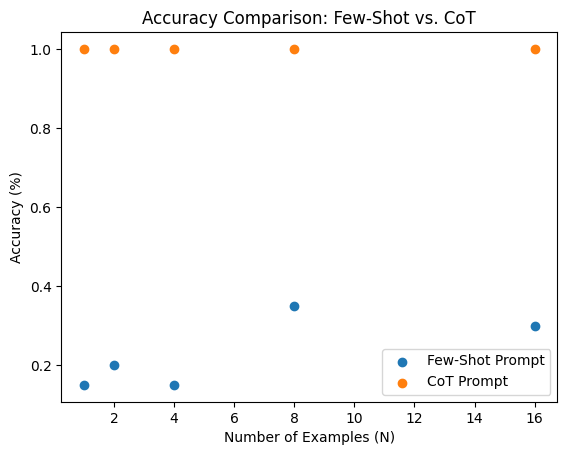

In [27]:
# TODO - Solve Problem 5.1 here

# regular few-shot examples

def Score_Prompt(Prompt):
  score = 0
  number = len(concatenation_X)
  for i in range(number):
    question = concatenation_X[i]
    answer = concatenation_y[i]
    gpt3_output = run_gpt3(Prompt.replace("{input}", question), instruction_tuned=True)
    if gpt3_output[-2:] == answer:
      score +=1

  return score/number

scores_few_shot = []
ONE_FEW_SHOT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them -> no,
{input}
'''
scores_few_shot.append(Score_Prompt(ONE_FEW_SHOT_CONCATENATION_PROMPT))

TWO_FEW_SHOT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them -> no,
Take the last letters of the words 'Otto Bot' and concatenate them -> ot,
{input}
'''
scores_few_shot.append(Score_Prompt(TWO_FEW_SHOT_CONCATENATION_PROMPT))

FOUR_FEW_SHOT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them -> no,
Take the last letters of the words 'Otto Bot' and concatenate them -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them -> gt,
Take the last letters of the words 'Jacob Emil' and concatenate them -> bl,
{input}
'''
scores_few_shot.append(Score_Prompt(FOUR_FEW_SHOT_CONCATENATION_PROMPT))

EIGHT_FEW_SHOT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them -> no,
Take the last letters of the words 'Otto Bot' and concatenate them -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them -> gt,
Take the last letters of the words 'Jacob Emil' and concatenate them -> bl,
Take the last letters of the words 'Daniel Lee' and concatenate them -> le,
Take the last letters of the words 'Samantha Green' and concatenate them -> an,
Take the last letters of the words 'Alex Turner' and concatenate them -> xr,
Take the last letters of the words 'Emily Davis' and concatenate them -> ys,
{input}
'''
scores_few_shot.append(Score_Prompt(EIGHT_FEW_SHOT_CONCATENATION_PROMPT))

SIXTEEN_FEW_SHOT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them -> no,
Take the last letters of the words 'Otto Bot' and concatenate them -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them -> gt,
Take the last letters of the words 'Jacob Emil' and concatenate them -> bl,
Take the last letters of the words 'Daniel Lee' and concatenate them -> le,
Take the last letters of the words 'Samantha Green' and concatenate them -> an,
Take the last letters of the words 'Alex Turner' and concatenate them -> xr,
Take the last letters of the words 'Emily Davis' and concatenate them -> ys,
Take the last letters of the words 'Victor Kim' and concatenate them -> rm,
Take the last letters of the words 'Grace Miller' and concatenate them -> er,
Take the last letters of the words 'Marcus Ford' and concatenate them -> sd,
Take the last letters of the words 'Natalie Chen' and concatenate them -> en,
Take the last letters of the words 'Eva Baker' and concatenate them -> ar,
Take the last letters of the words 'Lucas Zhang' and concatenate them -> sg,
Take the last letters of the words 'Sophia Hall' and concatenate them -> al,
Take the last letters of the words 'Andrew Lewis' and concatenate them -> ws,
{input}
'''
scores_few_shot.append(Score_Prompt(SIXTEEN_FEW_SHOT_CONCATENATION_PROMPT))


# chain-of-thought
scores_cot = []

ONE_COT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them
the last letter of 'Alvin' is 'n' the last letter of 'Bao' is o -> no,
{input}
'''
scores_cot.append(Score_Prompt(ONE_COT_CONCATENATION_PROMPT))

TWO_COT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them
the last letter of 'Alvin' is 'n' the last letter of 'Bao' is o -> no,
Take the last letters of the words 'Otto Bot' and concatenate them
the last letter of 'Otto' is 'o' the last letter of 'Bot' is t -> ot,
{input}
'''
scores_cot.append(Score_Prompt(TWO_COT_CONCATENATION_PROMPT))

FOUR_COT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them
the last letter of 'Alvin' is 'n' the last letter of 'Bao' is o -> no,
Take the last letters of the words 'Otto Bot' and concatenate them
the last letter of 'Otto' is 'o' the last letter of 'Bot' is t -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them
the last letter of 'Behrang' is 'g' and the last letter of 'Mohit' is 't' -> gt,
Take the last letters of the words 'Jacob Emil' and concatenate them
the last letter of 'Jacob' is 'b', and the last letter of 'Emil' is 'l' -> bl,
{input}
'''
scores_cot.append(Score_Prompt(FOUR_COT_CONCATENATION_PROMPT))

EIGHT_COT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them
the last letter of 'Alvin' is 'n' the last letter of 'Bao' is o -> no,
Take the last letters of the words 'Otto Bot' and concatenate them
the last letter of 'Otto' is 'o' the last letter of 'Bot' is t -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them
the last letter of 'Behrang' is 'g' and the last letter of 'Mohit' is 't' -> gt,
Take the last letters of the words 'Jacob Emil' and concatenate them
the last letter of 'Jacob' is 'b', and the last letter of 'Emil' is 'l' -> bl,
Take the last letters of the words 'Daniel Lee' and concatenate them
the last letter of 'Daniel' is 'l', and the last letter of 'Lee' is 'e' -> le,
Take the last letters of the words 'Samantha Green' and concatenate them
the last letter of 'Samantha' is 'a', and the last letter of 'Green' is 'n' -> an,
Take the last letters of the words 'Alex Turner' and concatenate them
the last letter of 'Alex' is 'x', and the last letter of 'Turner' is 'r' -> xr,
Take the last letters of the words 'Emily Davis' and concatenate them
the last letter of 'Emily' is 'y', and the last letter of 'Davis' is 's' -> ys,
{input}
'''
scores_cot.append(Score_Prompt(EIGHT_COT_CONCATENATION_PROMPT))

SIXTEEN_COT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them
the last letter of 'Alvin' is 'n' the last letter of 'Bao' is o -> no,
Take the last letters of the words 'Otto Bot' and concatenate them
the last letter of 'Otto' is 'o' the last letter of 'Bot' is t -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them
the last letter of 'Behrang' is 'g' and the last letter of 'Mohit' is 't' -> gt,
Take the last letters of the words 'Jacob Emil' and concatenate them
the last letter of 'Jacob' is 'b', and the last letter of 'Emil' is 'l' -> bl,
Take the last letters of the words 'Daniel Lee' and concatenate them
the last letter of 'Daniel' is 'l', and the last letter of 'Lee' is 'e' -> le,
Take the last letters of the words 'Samantha Green' and concatenate them
the last letter of 'Samantha' is 'a', and the last letter of 'Green' is 'n' -> an,
Take the last letters of the words 'Alex Turner' and concatenate them
the last letter of 'Alex' is 'x', and the last letter of 'Turner' is 'r' -> xr,
Take the last letters of the words 'Emily Davis' and concatenate them
the last letter of 'Emily' is 'y', and the last letter of 'Davis' is 's' -> ys,
Take the last letters of the words 'Victor Kim' and concatenate them:
the last letter of 'Victor' is 'r', and the last letter of 'Kim' is 'm' -> rm,
Take the last letters of the words 'Grace Miller' and concatenate them
the last letter of 'Grace' is 'e', and the last letter of 'Miller' is 'r' -> er,
Take the last letters of the words 'Marcus Ford' and concatenate them
the last letter of 'Marcus' is 's', and the last letter of 'Ford' is 'd' -> sd,
Take the last letters of the words 'Natalie Chen' and concatenate them
the last letter of 'Natalie' is 'e', and the last letter of 'Chen' is 'n' -> en,
Take the last letters of the words 'Eva Baker' and concatenate them
the last letter of 'Eva' is 'a', and the last letter of 'Baker' is 'r' -> ar,
Take the last letters of the words 'Lucas Zhang' and concatenate them
the last letter of 'Lucas' is 's', and the last letter of 'Zhang' is 'g' -> sg,
Take the last letters of the words 'Sophia Hall' and concatenate them
the last letter of 'Sophia' is 'a', and the last letter of 'Hall' is 'l' -> al,
Take the last letters of the words 'Andrew Lewis' and concatenate them
the last letter of 'Andrew' is 'w', and the last letter of 'Lewis' is 's' -> ws,
{input}
'''
scores_cot.append(Score_Prompt(SIXTEEN_COT_CONCATENATION_PROMPT))


import matplotlib.pyplot as plt

N_examples = [1, 2, 4, 8, 16]

plt.scatter(N_examples, scores_few_shot, label='Few-Shot Prompt')
plt.scatter(N_examples, scores_cot, label='CoT Prompt')

plt.xlabel('Number of Examples (N)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison: Few-Shot vs. CoT')
plt.legend()
plt.show()


**Please respond to the following question in your `report.pdf`**

**Problem 5.2 (EXTRA CREDIT):** Your job is to investigate whether or not COT can extend to lengths of words not seen in the chain-of-thought examples.

- Step 1: Try running the original concatenation prompt on a name or phrase with 3 words e.g. 'James Earl Jones' (try running it on at least 4-5 names or phrases). Does it work?
- Step 2: Go back and modify the prompt to get it to work
- Step 3: Now try running this on a name or phrase with 5 words (try running it on at least 4-5 names or phrases). Does it work? If not, how would you extend the prompt to get it to work?

Should you decide to do this exploration, in your report, please include what prompts you tried, at least 3 examples of names you tried the prompts on (3 word and 5 word), and an explanation of why you tried what you tried

Feel free to reference [Chain-of-Thought Prompting Elicits Reasoning in Large Language Models](https://arxiv.org/pdf/2201.11903.pdf), especially section 5 on Symbolic Reasoning.

In [70]:
# TODO (EXTRA CREDIT) Modify the following prompt
MODIFIED_THREE_WORD_COT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin Bao' and concatenate them
the last letter of 'Alvin' is 'n' the last letter of 'Bao' is o -> no,
Take the last letters of the words 'Otto Bot' and concatenate them
the last letter of 'Otto' is 'o' the last letter of 'Bot' is t -> ot,
Take the last letters of the words 'Behrang Mohit' and concatenate them
the last letter of 'Behrang' is 'g' and the last letter of 'Mohit' is 't' -> gt,
Take the last letters of the words 'Jacob Emil' and concatenate them
the last letter of 'Jacob' is 'b', and the last letter of 'Emil' is 'l' -> bl,
{input}
'''
print(run_gpt3(MODIFIED_THREE_WORD_COT_CONCATENATION_PROMPT.replace("{input}", "Take the last letters of the words 'Stephen Curry James' and concatenate them"), instruction_tuned=True))
print(run_gpt3(MODIFIED_THREE_WORD_COT_CONCATENATION_PROMPT.replace("{input}", "Take the last letters of the words 'Stephen Curry James Alexanderwang Li' and concatenate them"), instruction_tuned=True))

the last letter of 'Stephen' is 'n', and the last letter of 'Curry' is 'y', and the last letter of 'James' is 's' -> nys
the last letter of 'Stephen' is 'n', the last letter of 'Curry' is 'y', the last letter of 'James' is 's', the last letter of 'Alexanderwang' is 'g', and the last letter of 'Li' is 'i' -> nysgi


In [71]:
# TODO unit tests
run_unit_test(MODIFIED_THREE_WORD_COT_CONCATENATION_PROMPT, "Take the last letters of the words 'Stephen Curry James' and concatenate them ->", "nys", instruction_tuned=True)
run_unit_test(MODIFIED_THREE_WORD_COT_CONCATENATION_PROMPT, "Take the last letters of the words 'Stephen Curry James Alexanderwang Li' and concatenate them ->", "nysgi", instruction_tuned=True)


Expected: nys
Actual: the last letter of 'Stephen' is 'n', the last letter of 'Curry' is 'y', and the last letter of 'James' is 's' -> nys
Expected: nysgi
Actual: the last letter of 'Stephen' is 'n', the last letter of 'Curry' is 'y', the last letter of 'James' is 's', the last letter of 'Alexanderwang' is 'g', and the last letter of 'Li' is 'i' -> nysgi


In [4]:
# TODO (EXTRA CREDIT) Modify the following prompt
MODIFIED_FIVE_WORD_COT_CONCATENATION_PROMPT = '''
Take the last letters of the words 'Alvin' and concatenate them
the last letter of 'Alvin' is 'n' -> n,
Take the last letters of the words 'Otto Bot' and concatenate them
the last letter of 'Otto' is 'o' the last letter of 'Bot' is t -> ot,
Take the last letters of the words 'Behrang Mohit Jones' and concatenate them
the last letter of 'Behrang' is 'g' and the last letter of 'Mohit' is 't' the last letter of 'Jones' is s -> gts,
Take the last letters of the words 'Jacob Emil Isabe' and concatenate them
the last letter of 'Jacob' is 'b', and the last letter of 'Emil' is 'l' the last letter of 'Isabe' is e -> ble,
{input}
'''
print(run_gpt3(MODIFIED_FIVE_WORD_COT_CONCATENATION_PROMPT .replace("{input}", "Take the last letters of the words 'Stephen Curry James Alexanderwang Lee' and concatenate them ->"), instruction_tuned=True))

the last letter of 'Stephen' is 'n', the last letter of 'Curry' is 'y', the last letter of 'James' is 's', the last letter of 'Alexanderwang' is 'g', and the last letter of 'Lee' is 'e' -> nysge


In [10]:
# TODO unit tests
run_unit_test(MODIFIED_FIVE_WORD_COT_CONCATENATION_PROMPT, "Take the last letters of the words 'Stephen Curry James Alexanderwang Lee' and concatenate them ->", "nysge", instruction_tuned=True)
run_unit_test(MODIFIED_FIVE_WORD_COT_CONCATENATION_PROMPT, "Take the last letters of the words 'first Friday of this month' and concatenate them ->", "tyfsh", instruction_tuned=True)
run_unit_test(MODIFIED_FIVE_WORD_COT_CONCATENATION_PROMPT, "Take the last letters of the words 'Sunset painted sky so beautiful' and concatenate them ->", "tdyol", instruction_tuned=True)
run_unit_test(MODIFIED_FIVE_WORD_COT_CONCATENATION_PROMPT, "Take the last letters of the words 'Do you like this story' and concatenate them ->", "ouesy", instruction_tuned=True)
run_unit_test(MODIFIED_FIVE_WORD_COT_CONCATENATION_PROMPT, "Take the last letters of the words 'Oliver Alice Jackson Oliv Noah' and concatenate them ->", "renvh", instruction_tuned=True)
run_unit_test(MODIFIED_FIVE_WORD_COT_CONCATENATION_PROMPT, "Take the last letters of the words 'Olive Sophia Jack Selina Amber' and concatenate them ->", "eakar", instruction_tuned=True)


Expected: nysge
Actual: the last letter of 'Stephen' is 'n', the last letter of 'Curry' is 'y', the last letter of 'James' is 's', the last letter of 'Alexanderwang' is 'g', and the last letter of 'Lee' is 'e' -> nysge
Expected: tyfsh
Actual: the last letter of 'first' is 't', the last letter of 'Friday' is 'y', the last letter of 'of' is 'f', the last letter of 'this' is 's', the last letter of 'month' is 'h' -> tyfsh
Expected: tdyol
Actual: the last letter of 'Sunset' is 't', the last letter of 'painted' is 'd', the last letter of 'sky' is 'y', the last letter of 'so' is 'o', and the last letter of 'beautiful' is 'l' -> tdyol
Expected: ouesy
Actual: the last letter of 'Do' is 'o', the last letter of 'you' is 'u', the last letter of 'like' is 'e', the last letter of 'this' is 's', the last letter of 'story' is 'y' -> ouesy
Expected: renvh
Actual: the last letter of 'Oliver' is 'r', the last letter of 'Alice' is 'e', the last letter of 'Jackson' is 'n', the last letter of 'Oliv' is 'v'

# Submissions

## Submission Checklist (check if you missed anything!)
We will look for the following:
- Section 1:
  - 1.1: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 1.2: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 1.3: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 1.4: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 1.5: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 1.6: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
- Section 2:
  - 2.1: Written response in `report.pdf` (Word Limit: 100 words)
  - 2.2: Written response in `report.pdf` and verification of prompt, verbalizers, and number correct
- Section 3:
  - 3.1: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 3.2: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 3.3: Written response in `report.pdf`
- Section 4:
  - 4.1: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 4.2: Prompt, 3 unit tests, and output included in `report.pdf` and notebook
  - 4.3: Written response in `report.pdf`
- Section 5:
  - 5.1: Written response (table/plot, short-write up) in `report.pdf` and verification of prompt and evaluation function (examples from cell output not required)
  - 5.2: **OPTIONAL**: Written response in `report.pdf` and verification of 2 prompts and 6 unit tests

For the purpose of submission, feel free to complete the entire assignment in the notebook and then convert it into a pdf for the report. However, this is not required as long as all of the deliverables above are satisfied.

**REMINDER**: Include the **expected** answer and the **response** from the OpenAI API in the cell output and `report.pdf` **for all unit tests**.

## GradeScope File Submission

**MAKE SURE TO REMOVE YOUR API KEY FROM YOUR SUBMISSION, YOU WILL LOSE POINTS IF YOUR API KEY IS PRESENT IN THE NOTEBOOK SUBMISSION**

Here are the deliverables you need to submit to GradeScope:
- Write-up (`report.pdf`):
    - All Sections
    - **IMPORTANT**: You will be assigning each page of the report to a question so please make sure you have the correct page(s) assigned to each question, **you will lose 10 points on this assignment if your answers are not assigned correctly**.
- Code:
    - This notebook: make sure it is named `HW4.ipynb` before submitting. You can download the notebook and py file by going to the top-left corner of this webpage, `File -> Download -> Download .ipynb`